# Single column matrix input file. IWP variation

Preparing matrix of 1D columns .nc file and formatting for input ecRad file.

Version 5: 2023-07-07

Fixed parameters:
1. Cosine of solar zenith angle $\mu = .6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006)
2. SW albedo $\alpha = .05$ (Hartmann & Berry, 2017).
3. LW emissivity $\epsilon = .97$ (REFERENCE?)
4. Skin temperature as surface temperature $T_{skin}$ of 290 to 300 K (Jin & Dickinson, 2010, https://iopscience.iop.org/article/10.1088/1748-9326/5/4/044004/pdf)
5. No gases and aerosols.
6. No liquid water.
7. Tropical sounding (Lapse Rate of $6.7\;K/km$ (see on next cells below)).

Variable parameters:
1. Ice Water Path (IWP) = .1, 1, 5:5:1000 $g/m^2$ (Sokol & Hartmann 2020):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/km)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = IWP{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$
2. Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
3. pysolar : 0.10
4. matplotlib : 3.6.2

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt

%matplotlib notebook

## Loading Data

In [2]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_81307/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [3]:
height          = tropical_profile['height (km)'].iloc[::-1]
temp            = tropical_profile['temperature (K)'].iloc[::-1]
tropopause_i    = temp.argmin()
tropopause      = temp.iloc[tropopause_i]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]

print(tropopause)

195.6


See "1D_ecrad_input_creator_height_v5.ipynb" for tropical sounding figures

## Preparing input

List of parameters:

- Skin Temperature (for each temperature)
- cos_solar_zenith_angle (for each temperature)
- pressure_hl (half level column)
- temperature_hl (half level column)
- q or h2o_mmr (Specific Humidity) (level column)
- o3_mmr (Ozone Mass Mixing Ratio) (level column)
- q_liquid (Liquid cloud mass mixing ratio (kg kg-1)) (level column)
- q_ice (Ice cloud mass mixing ratio (kg kg-1)) (level column)
- re_liquid (m) (level column)
- re_ice (m) (level column)
- cloud_fraction (level column)
- sw_albedo (1 value)
- lw_emissivity (1 value)
- aerosol_mmr (matrix)

### 1. Density Profile $(kg/m^3)$

In [4]:
R       = 287 # J/kgK
density = (tropical_profile['pressure (hPa)']*100)/(tropical_profile['temperature (K)']*R)
density = density.iloc[::-1]

### 2. Half Level Pressures (Pa)

"The half_level dimension corresponds to the mid-points of the levels, plus the top-of-atmosphere and surface, and so must be one more than level"

In [5]:
pressure_hli = [tropical_profile['pressure (hPa)'].iloc[-1]*100] # Pa
for i in range(len(tropical_profile['pressure (hPa)'])-1):
    pif = tropical_profile['pressure (hPa)'].iloc[-1-(i+1)]*100
    pii = tropical_profile['pressure (hPa)'].iloc[-1-i]*100
    pressure_hli.append((pif+pii)/2)
pressure_hli.append(tropical_profile['pressure (hPa)'].iloc[0]*100) # Pa

### 3. Half Level Temperatures (K)

Interpolation obtained from half level pressures:

In [6]:
temp_int        = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                       tropical_profile['temperature (K)'].iloc[::-1])
temperature_hli = temp_int(pressure_hli)

### 4. Matrix

Level of perturbation (236 K, 218 K, 201 K) with 1.5 km cloud depth:

In [57]:
perturbation_temp   = 201
perturbation_i      = (temp.iloc[tropopause_i:] - perturbation_temp).abs().argmin()
perturbation_height = height.iloc[tropopause_i+perturbation_i]
lower_limit_hi = height[height==(perturbation_height - .75)].index[0]
upper_limit_hi = height[height==(perturbation_height + .75)].index[0]

IWP from .1, 1, 5 to 1000 every 5 $g/m^2$

In [58]:
iwp  = np.arange(5,1005,5)
iwp  = np.append([.1, 1], iwp)
rows = len(iwp)
print(rows)

202


In [59]:
# Fixed parameters:
cos_solar_zenith_angle = np.full(rows, .6)
lw_emissivity          = np.full(rows, .97)
sw_albedo              = np.full(rows, .05)
skin_temperature       = np.full(rows, temp.iloc[-1]) # (K)

re = 30 # effective radius in um (30 from version 5)

# Specific humidity matrix (perturbations X level):
qi = tropical_profile['specific hum\t(kg/kg)'].iloc[::-1]
q  = np.full((rows,len(pressure_hli)-1),qi)

# Ozone mass mixing ratio matrix (perturbations X level):
o3_mmr = np.zeros((rows,len(pressure_hli)-1))

# Liquid cloud mass mixing ratio (perturbations X level):
q_liquid = np.zeros((rows,len(pressure_hli)-1))

# Ice cloud mass mixing ratio (perturbations X level):
q_ice = np.zeros((rows,len(pressure_hli)-1))

cloud_fraction = np.zeros((rows,len(pressure_hli)-1))

# CREATING THE PROFILE
for i in range(rows):
    for j in range(len(height)):
        hj = height.iloc[j]
        if hj >= (perturbation_height - .75) and hj <= (perturbation_height + .75):
                integral = np.trapz(density.iloc[lower_limit_hi:upper_limit_hi],
                                    height.iloc[lower_limit_hi:upper_limit_hi]*1000,0.1)
                q_ice[i,j] = (iwp[i]/abs(integral))*1e-3 # qi = IWP / int(rho dz) kg/kg
                cloud_fraction[i,j] = 1

# Liquid cloud effective radius (m):
re_liquid = np.full((rows,len(pressure_hli)-1),1e-5)

# Ice cloud effective radius (m):
re_ice = np.full((rows,len(pressure_hli)-1),re*1e-6)

# Half Level Pressures (perturbations X half_level):
pressure_hl = np.full((rows,len(pressure_hli)),pressure_hli)

# Half Level Temperatures (perturbations X half_level):
temperature_hl = np.full((rows,len(pressure_hli)),temperature_hli)

<IPython.core.display.Javascript object>


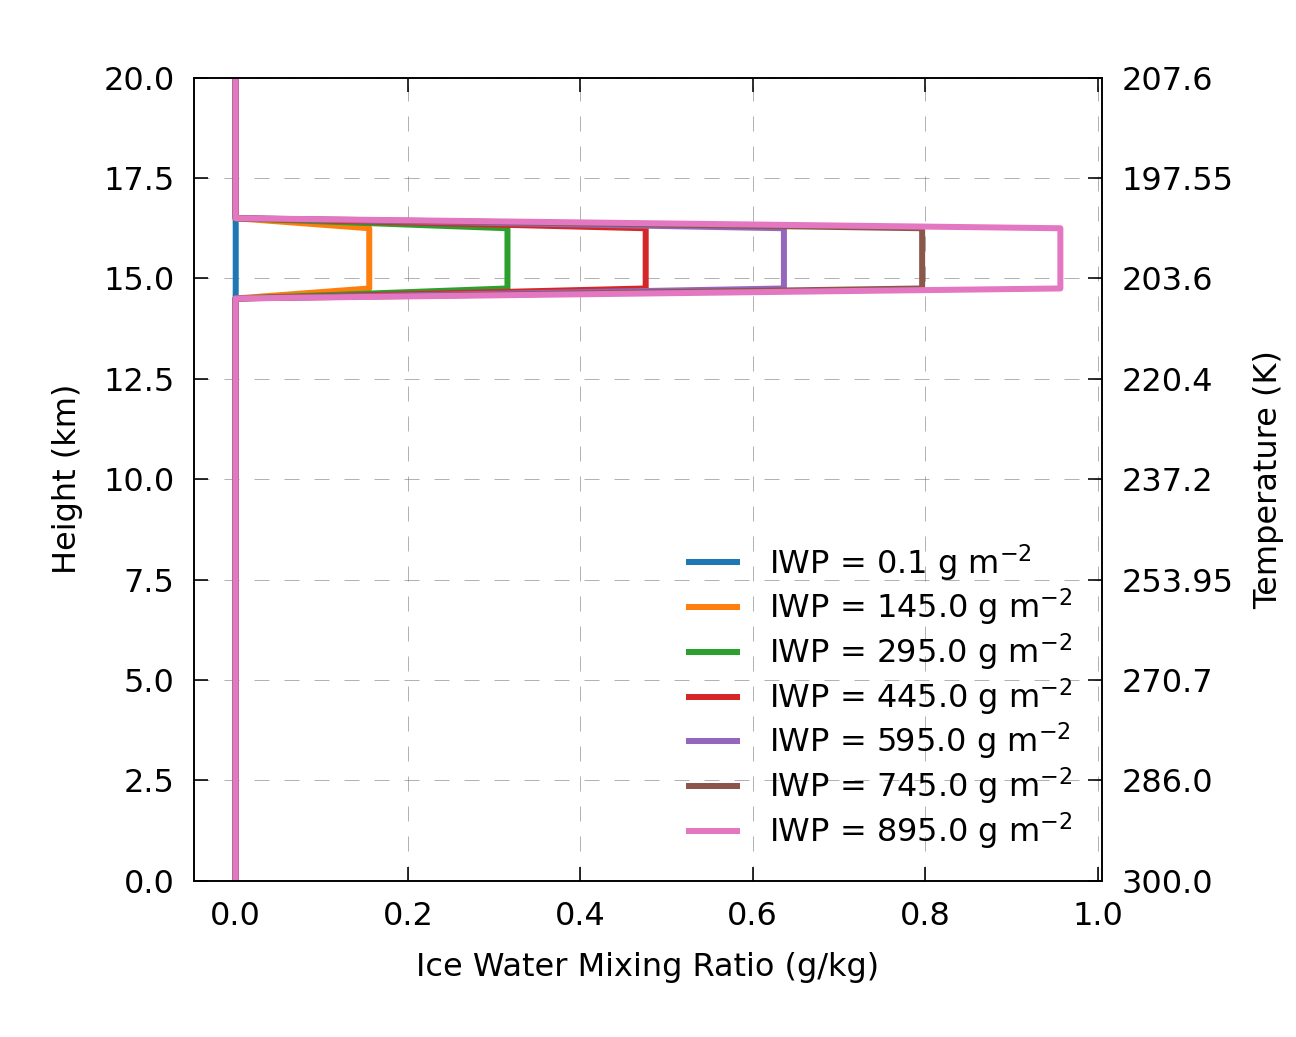

In [60]:
fontsize = 16
length   = 9 # inches
heigth   = length*.8 # inches
f, ax    = plt.subplots(figsize=(length,heigth), dpi=72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left =0.15, right = 0.85)

my_colors = [(88/255,148/255,197/255), (169/255,23/255,38/255),
             (229/255,179/255,69/255), (131/255,170/255,69/255),
             (116/255,24/255,123/255), (202/255,91/255,46/255),
             (107/255,188/255,233/255), 'grey']

handles = []
labels  = [] 
for i in np.arange(0,202,30):
    h = ax.plot(q_ice[i]*1000, tropical_profile['height (km)'].iloc[::-1],
                linestyle = 'solid', linewidth = 3)#,
                #color = my_colors[0], alpha = 1,
                #label = '200 K perturbation level')
    handles = handles + h
    labels.append('IWP = '+str(iwp[i])+r' g m$^{-2}$')

ax.grid('on', linestyle = 'dashed', color = 'grey',
        dashes = (25, 25), linewidth = .3)

# X Axis:
ax.set_xlabel('Ice Water Mixing Ratio (g/kg)', fontsize = fontsize,
              color = 'black', labelpad = 10)
#major_ticks_x = np.arange(-60,60,3)
#minor_ticks_x = np.arange(-60,60,1)
#ax.set_xticks(major_ticks_x)
#ax.set_xticks(minor_ticks_x, minor=True)
#ax.set_xlim(0, .5)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
#ax.tick_params(axis = 'x', which = 'minor',
#               color = 'black', size = 4,
#               direction = 'in', top = True)
    
# Y Axis:
ax.set_ylabel('Height (km)', fontsize = fontsize,
              color = 'black', labelpad = 10)
#major_ticks_y = np.arange(-60,60,3)
#minor_ticks_y = np.arange(-60,60,1)
#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0,20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)', fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0,22.5,2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)

#ax.text(0.95, 0.95, 'Perturbation levels',
#        ha = 'right', va = 'top', transform = ax.transAxes,
#        fontsize = fontsize, color = 'black')

# Legend:
#handles = h1 + h2 + h3 + h4
#labels  = ['200 K','212 K','224 K','236 K']    
legend  = plt.legend(handles, labels, loc = 'lower right',#bbox_to_anchor=(.675, 1.075),#
                     ncol = 1, handlelength = 1.5, handletextpad = 1,
                     labelspacing = .1, columnspacing = 2, numpoints = 1,
                     frameon = False, prop = {'size':fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
plt.savefig(out_dir+'1D_qi_iwp_profiles_'+str(perturbation_temp)+'_v5.png', dpi = 500)

### Final Table

In [61]:
ds = xr.Dataset(
    data_vars = dict(
        #time = (time),
        temp = (['column'], iwp),
        #longitude = (['column'], longitude),
        lw_emissivity = (['column'], lw_emissivity),
        sw_albedo = (['column'], sw_albedo),
        skin_temperature = (['column'], skin_temperature),
        cos_solar_zenith_angle = (['column'], cos_solar_zenith_angle),
        pressure_hl = (['column','half_level'], pressure_hl),
        temperature_hl = (['column','half_level'], temperature_hl),
        q = (['column','level'], q),
        o3_mmr = (['column','level'], o3_mmr),
        q_liquid = (['column','level'], q_liquid),
        q_ice = (['column','level'], q_ice),
        re_liquid = (['column','level'], re_liquid),
        re_ice = (['column','level'], re_ice),
        cloud_fraction = (['column','level'], cloud_fraction),
    ),
    attrs = dict(
        title="1D columns matrix input for ecRad"),
)

In [62]:
out_dir = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
file    = 'input_1D_matrix_iwp_'+str(perturbation_temp)+'_v5.nc'
ds.to_netcdf(path = out_dir+file)